In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax_cosmo as jc
import numpy
import matplotlib.pyplot as plt

In [2]:
def L_sn(wl):
    wl0=5500.
    sig2 = 1e6
    return jnp.exp(-(wl-wl0)**2/2/sig2)

In [3]:
@jit
def CCM_single(wl, Rv):
    def infrared(x, Rv):
        a = 0.574*x**1.61
        b = -0.527*x**1.61
        return a+b/Rv

    def optical(x, Rv):
        y=x-1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
        return a+b/Rv

    def ultraviolet(x, Rv):
        a = 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
        b = -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
        return a+b/Rv
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x,Rv), optical(x,Rv), ultraviolet(x,Rv)], default=0.)

In [4]:
@jit
def CCM(wl,Rv):
    return vmap(CCM_single,(0,None))(wl,Rv)

In [5]:
def flux_single(efflam, Av, Rv, z, cosmo):
    dl = (1+z)**2*jc.background.angular_diameter_distance(cosmo, 1/(1+z))
    restlam = efflam/(1+z)
    return 1/4/numpy.pi/dl**2 * L_sn(restlam) * 10**(-Av/2.5)*CCM_single(efflam, Rv)

In [6]:
def flux_lam(efflam, Av, Rv, z, cosmo):
    return vmap(flux_single,(0, None, None, None, None))(efflam, Av, Rv, z, cosmo)

In [7]:
def flux_all(efflam, Av, Rv, z, cosmo):
    return vmap(flux_lam,(None, 0, 0, 0, None))(efflam, Av, Rv, z, cosmo)

In [48]:
def lnL(Omega_c, w0, wa, dm_int, Avs, Rvs, zs ,fs, fsigs, efflam):
    cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    flux = flux_all(efflam, Avs, Rvs, zs, cosmo)
    return jnp.sum((fs-flux)**2 /(fsigs**2 + (numpy.log(10)/2.5*flux*dm_int)**2))

In [49]:
def simulate_flux(nsn = 100, dm_int = 0.1, dm_obs = 0.02, cosmo = jc.Planck15(), efflam = numpy.array([4700., 6420.,  7849.])):

    nlam = len(efflam)
    
    zs = numpy.linspace(0.01,1,nsn)
    Avs = numpy.random.uniform(0,0.001,nsn)
    Rvs = numpy.random.uniform(2,3.5,nsn)
    
    flux = flux_all(efflam,Avs,Rvs,zs,cosmo)
    dflux = numpy.log(10)/2.5 * flux * numpy.sqrt(dm_int**2 + dm_obs**2)
    flux = numpy.random.normal(flux, dflux)
    return zs, flux, numpy.log(10)/2.5 * flux * dm_obs, efflam, Avs, Rvs, cosmo

In [50]:
zs, flux, dflux, efflam, Avs, Rvs, cosmo = simulate_flux()

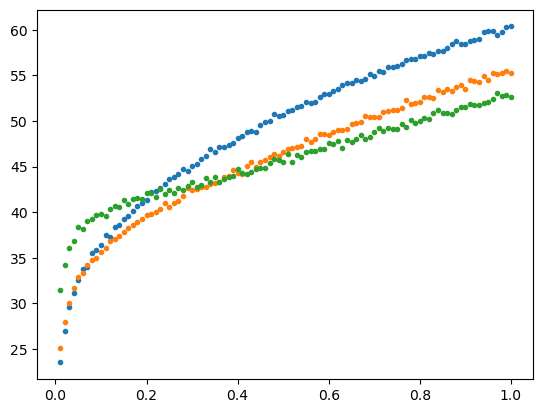

In [51]:
plt.plot(zs,-2.5*numpy.log(flux[:,:,0]),'.')

In [52]:
lnL_ = lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, 0.1, Avs, Rvs, zs ,flux, dflux, efflam)

In [53]:
lnL_

Array(263.94446, dtype=float32)

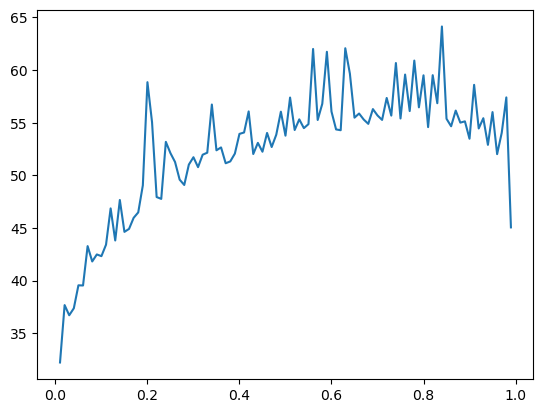

In [66]:
plt.plot(zs, -2.5*numpy.log(flux_sn(5000,Avs,Rvs,zs,cosmo)))

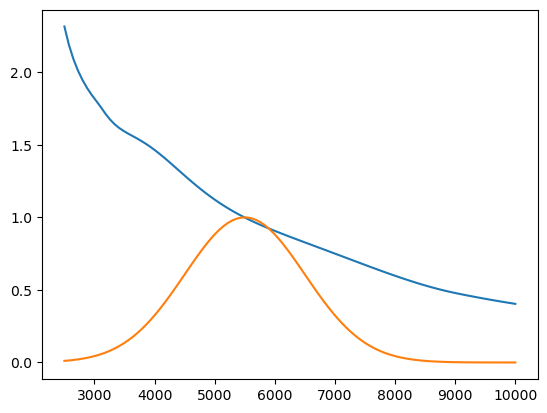

In [55]:
plt.plot(wl,CCM(wl,3.1))
plt.plot(wl,L_sn(wl))